Vary DNA concentration together include GFP DNA concentration

In [154]:
import sys,os
sys.path.append(os.path.realpath('..'))

from scripts.functions import dilute, replenish,dilute_species, replenish_species, run_model,plot_result,plot_result_two_state
from scripts.species import DNA, RNA, Protein, Resource
from scripts.models import Repressor_model_HC,Repressor_model
from bokeh.io import export_png


import numpy as np
import scipy.integrate
import scipy.optimize
from bokeh.plotting import figure, output_file, show
import bokeh.plotting
import bokeh.io
from bokeh.models import Span
import pandas as pd 


# We will use Matplotlib to make a 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import panel as pn
pn.extension()

bokeh.io.output_notebook()

Loading BokehJS ...

In [155]:

def Repressor_model_HC(molecules,t,alpha,beta,K,HC,Kr,KTL,KTX,lamb1,lamb2):
    T7_DNA,T7_RNA,T7,GFP_DNA,GFP_RNA,GFP,Repressor_DNA,Repressor_RNA,Repressor,R = molecules
    TX = 1
    TL = 1
    return np.array(
        [
            0,
            alpha*TX*T7_DNA*1*R/(R+K)*(Kr/(Repressor**HC+Kr)),
            beta*TL*T7_RNA*(R/(R+K)),
            0,
            alpha*TX*GFP_DNA*T7*R/(R+K),
            beta*TL*GFP_RNA*R/(R+K),
            0,
            alpha*TX*Repressor_DNA*T7*R/(R+K),
            beta*TL*Repressor_RNA*R/(R+K),
            -alpha*TX*T7_DNA*T7*R/(R+K)-alpha*TX*GFP_DNA*T7*R/(R+K)-alpha*TX*Repressor_DNA*T7*R/(R+K)-beta*TL*T7_RNA*R/(R+K)-beta*TL*GFP_RNA*R/(R+K)-beta*TL*Repressor_RNA*R/(R+K),
        ]
    )
    

In [160]:
#######Define species #######

#T7 RNAP
T7_DNA = DNA()
T7_RNA = RNA()
T7 = Protein()

#Repressor
Repressor_DNA = DNA()
Repressor_RNA = RNA()
Repressor = Protein()

#GFP
GFP_DNA = DNA()
GFP_RNA = RNA()
GFP = Protein()

#Resource
R      = Resource()

#Others
TX = 1
TL = 1

#list of molecules
molecules_list = [T7_DNA,T7_RNA,T7,GFP_DNA,GFP_RNA,GFP,Repressor_DNA,Repressor_RNA,Repressor,R]


#give index num
for i in range(0,len(molecules_list)):
    molecules_list[i].idx = i




#define values 
##T7
T7_DNA.ic =0.01
T7_DNA.lc =0.01

T7.ic = 1
T7.lc = 1

##GFP
GFP_DNA.ic = 2
GFP_DNA.lc = 2

GFP.lc = 0

##Repressor 
Repressor_DNA.ic = 0.01
Repressor_DNA.lc = 0.01


#resources
R.ic =100
R.lc =100

#Define parameters
alpha=0.7;
beta=0.07;
K=1.0;
Kr = 1;
HC = 1;
KTL=10;
KTX=1;
lamb1=0;
lamb2=0;

parameters_list = (alpha,beta,K,HC,Kr,KTL,KTX,lamb1,lamb2)

end_time = 30

end_cycle = end_time*4+1


In [161]:
#Define parameters
alpha=0.7;
beta=0.07;
K= 1.0;
Kr = 0.1;
HC = 1;
KTL=10;
KTX=1;
lamb1=0;
lamb2=0;

parameters_list = (alpha,beta,K,HC,Kr,KTL,KTX,lamb1,lamb2)

end_time = 30

end_cycle = end_time*4+1

steadystate_data = []
heatmap_data = []
screening_condition = []
T7_parameter_space = np.logspace(-4,2, 100, endpoint=True)
parameter_space = np.logspace(-4,2, 10, endpoint=True)

for condition in parameter_space:
    print(np.shape(np.array(heatmap_data)))    
    Kr = condition
    parameters_list = (alpha,beta,K,HC,Kr,KTL,KTX,lamb1,lamb2)
    steadystate_data = []


    for conc in T7_parameter_space:
        #experiment 
        T7_DNA.ic = conc
        T7_DNA.lc = conc
        Repressor_DNA.ic = 0.1
        Repressor_DNA.lc = 0.1
        GFP_DNA.ic = 2
        GFP_DNA.lc = 2
        #initial value
        molecules_0 = [None]*len(molecules_list) #create empty list

        for i in range(0,len(molecules_list)):
            molecules_0[i] = molecules_list[i].ic

        #stage 1 kick start
        result_all=[molecules_0] #initial condition


        #DR = 0.2

        #kick start
        dilution_list = [T7_RNA,T7,GFP,GFP_RNA,Repressor,Repressor_RNA,R]
        replenish_list = [T7,R]
        result_all,molecules_0 = run_model(Repressor_model_HC,(0,4),parameters_list,molecules_0,dilution_list,replenish_list,result_all)


        #self regeneration 
        dilution_list = [T7_RNA,T7,GFP,GFP_RNA,Repressor,Repressor_RNA,R]
        replenish_list = [R]
        result_all,molecules_0 = run_model(Repressor_model_HC,(4,30),parameters_list,molecules_0,dilution_list,replenish_list,result_all)


        result_all = np.resize(result_all,(end_cycle,10))
        for i in range(0,len(molecules_list)):
                (molecules_list[i]).result = result_all.transpose()[i]

        #T7_DNA,T7_RNA,T7,GFP_DNA,GFP_RNA,GFP,R = result_all.transpose()
        #plot_result_two_state(GFP.result)
        #print((GFP).result[60]/GFP.pc_result[60])
        steadystate_data.append((GFP).result[100])
    heatmap_data.append(steadystate_data)


(0,)
(1, 100)
(2, 100)
(3, 100)
(4, 100)
(5, 100)
(6, 100)
(7, 100)
(8, 100)
(9, 100)


In [162]:
df = pd.DataFrame(heatmap_data)
df = df.set_axis(np.round(T7_parameter_space,3),axis='columns')
df = df.set_axis(np.round(parameter_space,2),axis='rows')
#df = df.stack()

#import seaborn as sns
#sns.kdeplot(df)

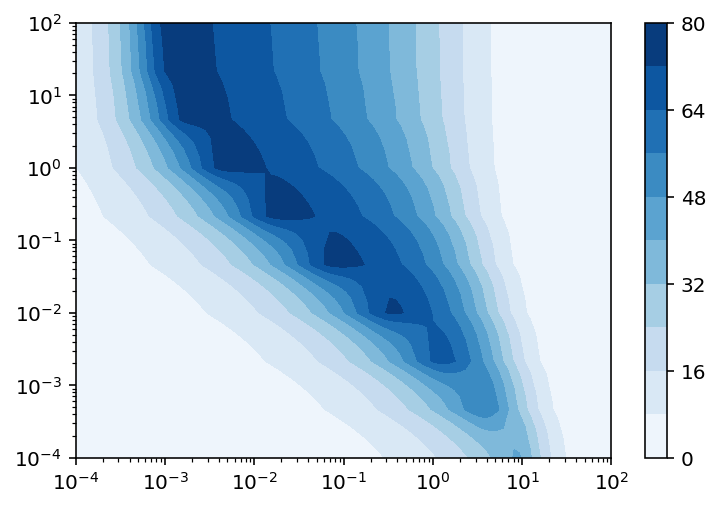

In [163]:
from matplotlib import pyplot as plt
plt.contourf(T7_parameter_space, parameter_space, heatmap_data,10,cmap='Blues')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()